Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5075d61782cd4c0886d0dc4f956298a5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/5075d61782cd4c0886d0dc4f956298a5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 80 RHS
At line 83 BOUNDS
At line 108 ENDATA
Problem MODEL has 2 rows, 24 columns and 48 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (0) rows, 24 (0) columns and 48 (0) elements
0  Obj 0 Primal inf 28.8 (1)
1  Obj 53.734353
Optimal - objective value 53.734353
Optimal objective 53.73435347 - 1 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Decision variables saved to 'decision_var.npy'


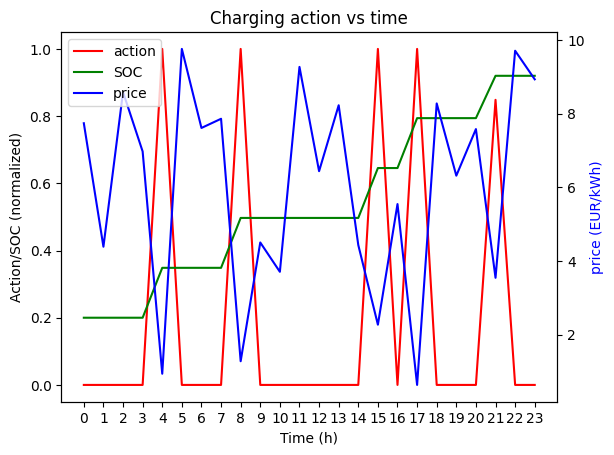

Charging schedule = [0.0, 0.0, 0.0, 0.0, 6.6, 0.0, 0.0, 0.0, 6.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.6, 0.0, 6.6, 0.0, 0.0, 0.0, 5.6, 0.0, 0.0]
Total bought energy in kWh = 32.0


In [3]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import pulp

# Instantiate parameters
rng = np.random.default_rng(seed=42)  # Random number generator for price vector
price = rng.random(24) * 10  # Vector containing 24 prices

# Constants
eta_c = 0.9
max_cap = 40
DeltaE = max_cap * (100 - 20) / 100
P_max = 6.6  # Maximum charging power

# Create the problem variable
problem = pulp.LpProblem("EV_Charging_Optimization", pulp.LpMinimize)

# Variables for the MILP problem
P_G2Vi_t = [pulp.LpVariable(f"P_G2Vi_t{i}", 0, P_max) for i in range(24)]

# Objective function
problem += pulp.lpSum(price[t] * P_G2Vi_t[t] for t in range(24)), "Total Charging Cost"

# Constraints
# Ensure the total energy charged is within a specific range
problem += pulp.lpSum(P_G2Vi_t[t] * eta_c for t in range(24)) >= 0.9 * DeltaE, "constraint1_lower"
problem += pulp.lpSum(P_G2Vi_t[t] * eta_c for t in range(24)) <= 1.1 * DeltaE, "constraint1_upper"

# Solve the problem
problem.solve()

# Extract decision variables
decision_var = [v.varValue for v in P_G2Vi_t]

# Save decision variables
np.save('decision_var.npy', decision_var)
print("Decision variables saved to 'decision_var.npy'")

# Calculate state of charge (SOC) assuming initial SOC of 20%
initial_soc = 20
soc_list = [initial_soc]
for t in range(24):
    soc_list.append(soc_list[-1] + decision_var[t] * eta_c * 100 / max_cap)
soc_array = np.array(soc_list[1:])

# Plotting
x = np.arange(24)
y1 = [var / P_max for var in decision_var]  # Total charging action normalized by P_max
y2 = soc_array / 100  # SOC normalized to 1
y3 = price

fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='r', label='action')
ax1.plot(x, y2, color='green', label='SOC')
ax1.set_title('Charging action vs time')
ax1.set_xticks(x)
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Action/SOC (normalized)', color='black')

ax2 = ax1.twinx()
ax2.plot(x, y3, color='b', label='price')
ax2.set_ylabel('price (EUR/kWh)', color='b')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

print(f"Charging schedule = {decision_var}")
print(f"Total bought energy in kWh = {sum(decision_var)}")


/home/michall/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/27d98cab7549455d85c1543ee1965c91-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/27d98cab7549455d85c1543ee1965c91-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 80 RHS
At line 83 BOUNDS
At line 108 ENDATA
Problem MODEL has 2 rows, 24 columns and 48 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (0) rows, 15 (-9) columns and 30 (-18) elements
0  Obj 0 Primal inf 28.799999 (1)
1  Obj 189.59758
Optimal - objective value 189.59758
After Postsolve, objective 189.59758, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 189.597579 - 1 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):      

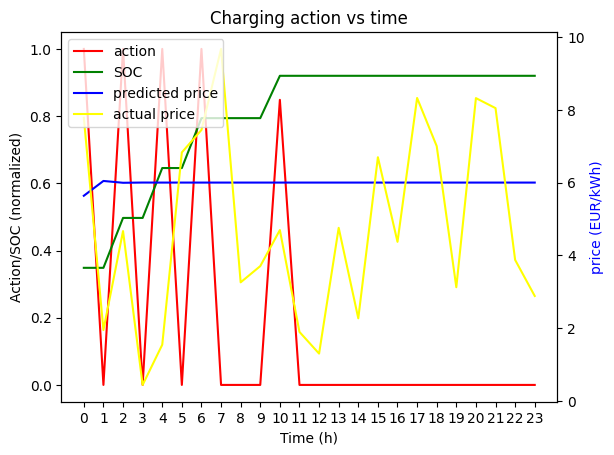

Charging schedule = [6.6, 0.0, 6.6, 0.0, 6.6, 0.0, 6.6, 0.0, 0.0, 0.0, 5.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total bought energy in kWh = 32.0


In [1]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import pulp
from statsmodels.tsa.arima.model import ARIMA

# Instantiate parameters
rng = np.random.default_rng(seed=42)  # Random number generator for price vector
price = rng.random(48) * 10  # Vector containing 48 prices

# Use the first half of the price vector to predict the next prices
train_prices = price[:24]
model = ARIMA(train_prices, order=(1, 1, 1))
model_fit = model.fit()
predicted_prices = model_fit.predict(start=24, end=47)

# Constants
eta_c = 0.9
max_cap = 40
DeltaE = max_cap * (100 - 20) / 100
P_max = 6.6  # Maximum charging power

# Create the problem variable
problem = pulp.LpProblem("EV_Charging_Optimization", pulp.LpMinimize)

# Variables for the MILP problem
P_G2Vi_t = [pulp.LpVariable(f"P_G2Vi_t{i}", 0, P_max) for i in range(24)]

# Objective function
problem += pulp.lpSum(predicted_prices[t-24]*P_G2Vi_t[t] for t in range(24)), "Total Charging Cost"

# Constraints
problem += pulp.lpSum(P_G2Vi_t[t]*eta_c for t in range(24)) >= 0.9*DeltaE, "constraint1_lower"
problem += pulp.lpSum(P_G2Vi_t[t]*eta_c for t in range(24)) <= 1.1*DeltaE, "constraint1_upper"

# Solve the problem
problem.solve()

# Extract decision variables and save them
decision_var = [v.varValue for v in P_G2Vi_t]
np.save('decision_var.npy', decision_var)
print("Decision variables saved to 'decision_var.npy'")

# Calculate state of charge (SOC) assuming initial SOC of 20%
initial_soc = 20
soc_list = [initial_soc]
for t in range(24):
    soc_list.append(soc_list[-1] + decision_var[t] * eta_c * 100 / max_cap)
soc_array = np.array(soc_list[1:])

# Plotting
x = np.arange(24)
y1 = [var / P_max for var in decision_var]  # Total charging action normalized by P_max
y2 = soc_array / 100  # SOC normalized to 1
y3 = predicted_prices  # Predicted prices
y4 = price[24:48]  # Actual prices

fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='r', label='action')
ax1.plot(x, y2, color='green', label='SOC')
ax1.set_title('Charging action vs time')
ax1.set_xticks(x)
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Action/SOC (normalized)', color='black')

ax2 = ax1.twinx()
ax2.plot(x, y3, color='b', label='predicted price')
ax2.plot(x, y4, color='yellow', label='actual price')
ax2.set_ylabel('price (EUR/kWh)', color='b')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

print(f"Charging schedule = {decision_var}")
print(f"Total bought energy in kWh = {sum(decision_var)}")


In [9]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

# Load the data
data = pd.read_excel('energy_prices.xlsx')
print(data.head())

  Beschikbaar gesteld door jeroen.nl            Unnamed: 1
0                          datumtijd  Inkoop prijs per kWh
1                2013-01-01 01:00:00                0.0326
2                2013-01-01 02:00:00                0.0316
3                2013-01-01 03:00:00                0.0306
4                2013-01-01 04:00:00                0.0293


In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary
import pickle

data = pd.read_excel('energy_prices.xlsx', skiprows=1)

# Check the column names
print(data.columns)

# Rename columns if necessary (adjust to match your file's column names)
data.columns = ['datumtijd', 'Inkoop prijs per kWh']

# Ensure the datetime column is in the correct format
data['datumtijd'] = pd.to_datetime(data['datumtijd'])
data.set_index('datumtijd', inplace=True)

# Resample data to hourly average if necessary
data = data.resample('H').mean()

start_date_train = data.index.min()
end_date_train = start_date_train + pd.DateOffset(years=1)

start_date_test = end_date_train
end_date_test = start_date_test + pd.DateOffset(years=1)

train_data = data.loc[start_date_train:end_date_train]
test_data = data.loc[start_date_test:end_date_test]

# Fit SARIMA model (parameters can be tuned)
sarima_model = sm.tsa.statespace.SARIMAX(train_data['Inkoop prijs per kWh'],
                                         order=(1, 1, 3),
                                         seasonal_order=(0, 1, 1, 1440)).fit()
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(sarima_model, f)

Index(['datumtijd', 'Inkoop prijs per kWh'], dtype='object')


/tmp/ipykernel_98417/1902943762.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('H').mean()


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary
import pickle

data = pd.read_excel('energy_prices.xlsx', skiprows=1)

# Check the column names
print(data.columns)

# Rename columns if necessary (adjust to match your file's column names)
data.columns = ['datumtijd', 'Inkoop prijs per kWh']

# Ensure the datetime column is in the correct format
data['datumtijd'] = pd.to_datetime(data['datumtijd'])
data.set_index('datumtijd', inplace=True)

# Resample data to hourly average if necessary
data = data.resample('H').mean()

start_date_train = data.index.min()
end_date_train = start_date_train + pd.DateOffset(years=1)

start_date_test = end_date_train
end_date_test = start_date_test + pd.DateOffset(years=1)

train_data = data.loc[start_date_train:end_date_train]
test_data = data.loc[start_date_test:end_date_test]

# Load the SARIMA model from a file
with open('sarima_model.pkl', 'rb') as f:
    sarima_model = pickle.load(f)

# Forecast
sarima_forecast = sarima_model.get_forecast(steps=len(test_data))
forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data['Inkoop prijs per kWh'], label='Train')
plt.plot(test_data['Inkoop prijs per kWh'], label='Test')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=.2)
plt.ylim(-2, 2)  # Set y-axis limits
plt.legend()
plt.show()

# Define the model
model = LpProblem("EV_Charging", LpMinimize)

# Parameters
T = len(test_data)
C = 10  # Number of cars
Pmax = 7  # Maximum charging power per car (kW)
Emax = 50  # Maximum battery capacity per car (kWh)
eta_ch = 0.9  # Charging efficiency
prices = sarima_forecast.predicted_mean.values

# Variables
P = LpVariable.dicts("P", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Pmax, cat='Continuous')
E = LpVariable.dicts("E", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Emax, cat='Continuous')
u = LpVariable.dicts("u", ((c, t) for c in range(C) for t in range(T)), cat='Binary')

# Objective: Minimize total cost
model += lpSum(prices[t] * P[c, t] for c in range(C) for t in range(T))

# Constraints
for c in range(C):
    for t in range(T):
        if t == 0:
            model += E[c, t] == 0  # Initial SoC
        else:
            model += E[c, t] == E[c, t-1] + eta_ch * P[c, t]
        model += P[c, t] <= Pmax * u[c, t]  # Power limits
        model += E[c, t] <= Emax  # SoC limits

# Solve the problem
model.solve()

# Extract results
charging_power = pd.DataFrame([[P[c, t].varValue for t in range(T)] for c in range(C)])
soc = pd.DataFrame([[E[c, t].varValue for t in range(T)] for c in range(C)])

# Plot the State of Charge (SoC) for each car
plt.figure(figsize=(14, 8))
for c in range(C):
    plt.plot(soc.iloc[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('State of Charge (kWh)')
plt.legend()
plt.show()

# Plot the charging power against electricity prices
plt.figure(figsize=(14, 8))
plt.plot(prices, label='Electricity Prices')
plt.plot(charging_power.sum(axis=0), label='Total Charging Power')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW) / Price (€)')
plt.ylim(0, 2)  # Set y-axis limits
plt.legend()
plt.show()


Index(['datumtijd', 'Inkoop prijs per kWh'], dtype='object')


/tmp/ipykernel_98417/4005814684.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('H').mean()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.65692D+00    |proj g|=  5.44007D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4     12      1     0     0   2.262D-01  -3.715D+00
  F =  -3.7151619920187007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


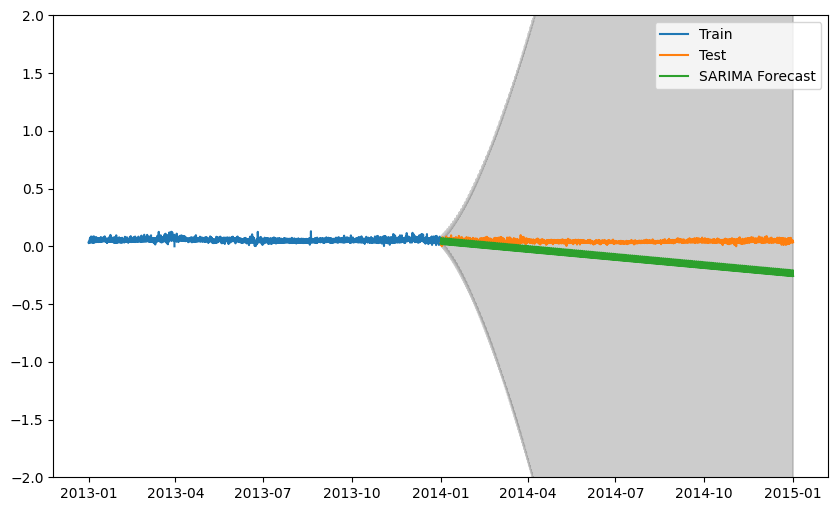

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c826bcd3b1e24942a6f419ece6a32709-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/c826bcd3b1e24942a6f419ece6a32709-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 262835 COLUMNS
At line 1051306 RHS
At line 1314137 BOUNDS
At line 1576968 ENDATA
Problem MODEL has 262830 rows, 262830 columns and 525640 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -142.892 - 0.25 seconds
Cgl0004I processed model has 10 rows, 87600 columns (0 integer (0 of which binary)) and 87600 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -142.892 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding

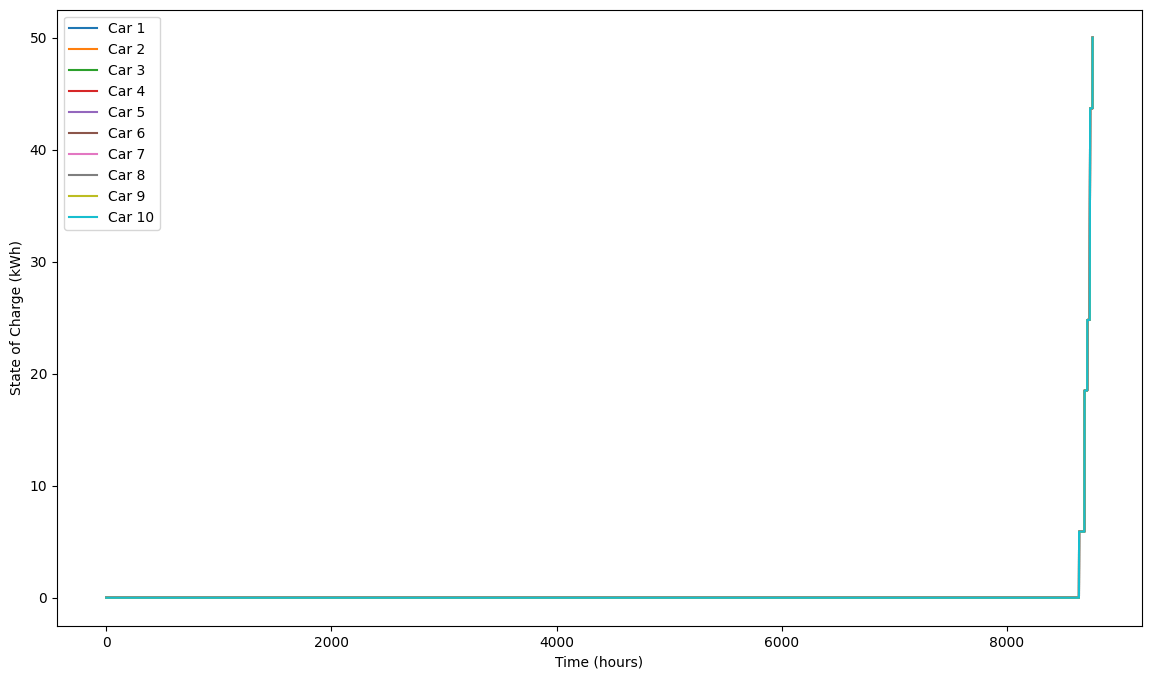

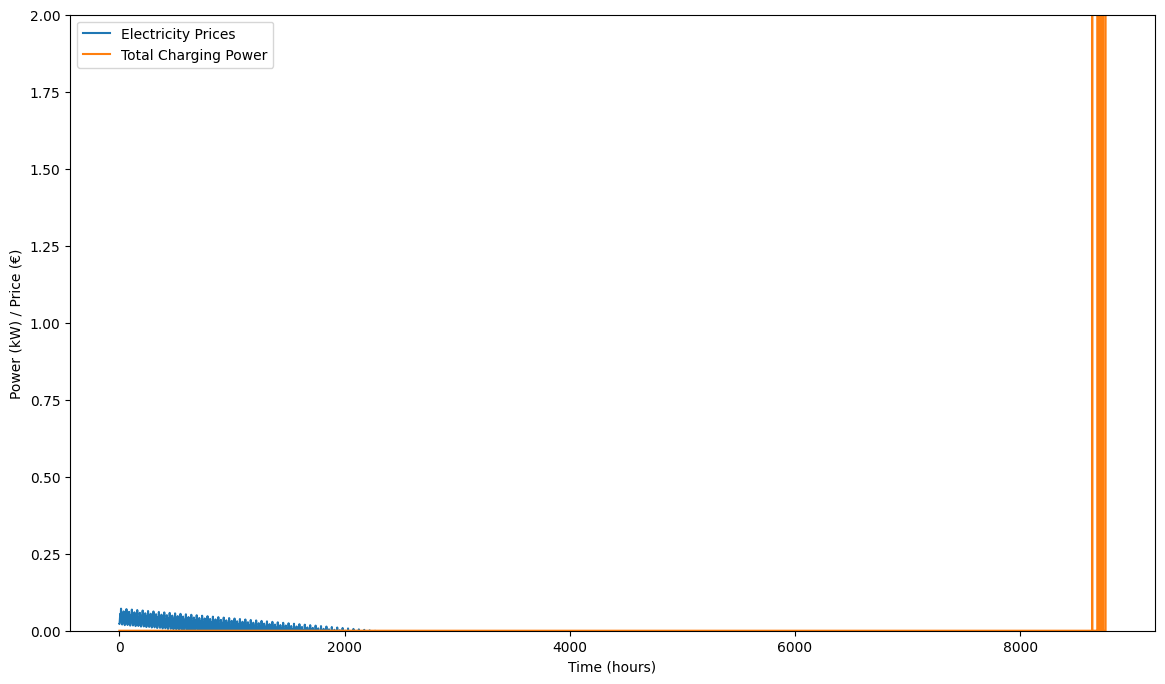

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

data = pd.read_excel('energy_prices.xlsx', skiprows=1)

# Check the column names
print(data.columns)

# Rename columns if necessary (adjust to match your file's column names)
data.columns = ['datumtijd', 'Inkoop prijs per kWh']

# Ensure the datetime column is in the correct format
data['datumtijd'] = pd.to_datetime(data['datumtijd'])
data.set_index('datumtijd', inplace=True)

# Resample data to hourly average if necessary
data = data.resample('H').mean()

start_date_train = data.index.min()
end_date_train = start_date_train + pd.DateOffset(years=1)

start_date_test = end_date_train
end_date_test = start_date_test + pd.DateOffset(years=1)

train_data = data.loc[start_date_train:end_date_train]
test_data = data.loc[start_date_test:end_date_test]

# Fit SARIMA model (parameters can be tuned)
sarima_model = sm.tsa.statespace.SARIMAX(train_data['Inkoop prijs per kWh'],
                                         order=(1, 1, 3),
                                         seasonal_order=(0, 1, 1, 48)).fit()

# Forecast
sarima_forecast = sarima_model.get_forecast(steps=len(test_data))
forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data['Inkoop prijs per kWh'], label='Train')
plt.plot(test_data['Inkoop prijs per kWh'], label='Test')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=.2)
plt.ylim(-2, 2)  # Set y-axis limits
plt.legend()
plt.show()

# Define the model
model = LpProblem("EV_Charging", LpMinimize)

# Parameters
T = len(test_data)
C = 10  # Number of cars
Pmax = 7  # Maximum charging power per car (kW)
Emax = 50  # Maximum battery capacity per car (kWh)
eta_ch = 0.9  # Charging efficiency
prices = sarima_forecast.predicted_mean.values

# Variables
P = LpVariable.dicts("P", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Pmax, cat='Continuous')
E = LpVariable.dicts("E", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Emax, cat='Continuous')
u = LpVariable.dicts("u", ((c, t) for c in range(C) for t in range(T)), cat='Binary')

# Objective: Minimize total cost
model += lpSum(prices[t] * P[c, t] for c in range(C) for t in range(T))

# Constraints
for c in range(C):
    for t in range(T):
        if t == 0:
            model += E[c, t] == 0  # Initial SoC
        else:
            model += E[c, t] == E[c, t-1] + eta_ch * P[c, t]
        model += P[c, t] <= Pmax * u[c, t]  # Power limits
        model += E[c, t] <= Emax  # SoC limits

# Solve the problem
model.solve()

# Extract results
charging_power = pd.DataFrame([[P[c, t].varValue for t in range(T)] for c in range(C)])
soc = pd.DataFrame([[E[c, t].varValue for t in range(T)] for c in range(C)])

# Plot the State of Charge (SoC) for each car
plt.figure(figsize=(14, 8))
for c in range(C):
    plt.plot(soc.iloc[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('State of Charge (kWh)')
plt.legend()
plt.show()

# Plot the charging power against electricity prices
plt.figure(figsize=(14, 8))
plt.plot(prices, label='Electricity Prices')
plt.plot(charging_power.sum(axis=0), label='Total Charging Power')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW) / Price (€)')
plt.ylim(0, 2)  # Set y-axis limits
plt.legend()
plt.show()


Index(['datumtijd', 'Inkoop prijs per kWh'], dtype='object')
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.65009D+00    |proj g|=  5.03731D+01


/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -3.68605D+00    |proj g|=  1.56086D-01

At iterate   10    f= -3.70407D+00    |proj g|=  2.00965D+01

At iterate   15    f= -3.71298D+00    |proj g|=  1.21718D+01

At iterate   20    f= -3.74404D+00    |proj g|=  1.68208D-01

At iterate   25    f= -3.75894D+00    |proj g|=  2.46495D-01

At iterate   30    f= -3.76889D+00    |proj g|=  6.20035D-01

At iterate   35    f= -3.77024D+00    |proj g|=  1.04205D+01

At iterate   40    f= -3.77264D+00    |proj g|=  3.95984D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     64      1     0     0   1.032D+00  -3.773D+00
  F =  -3.77292095968

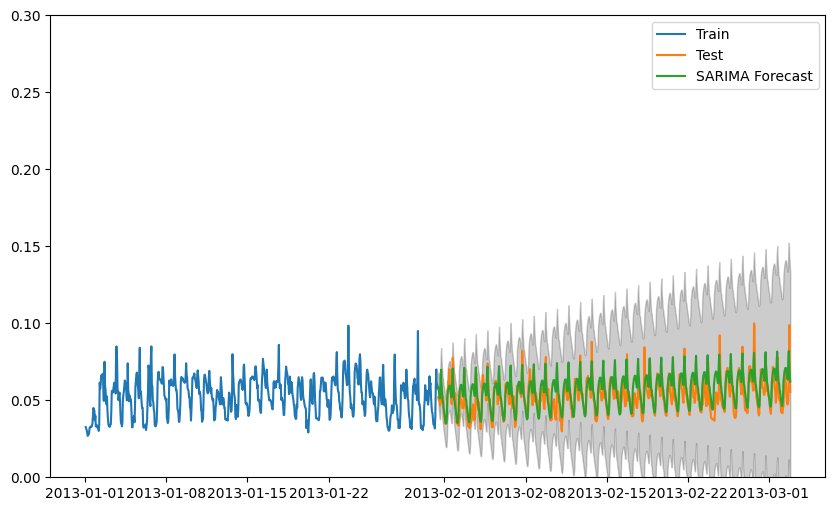

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/48e68067959b4eccbe93cbdaecc8ad54-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/48e68067959b4eccbe93cbdaecc8ad54-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21905 COLUMNS
At line 87586 RHS
At line 109487 BOUNDS
At line 131388 ENDATA
Problem MODEL has 21900 rows, 21900 columns and 43780 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
using 0 columns not 3000
7150 slacks added
Continuous objective value is 0 - 0.02 seconds
Cgl0004I processed model has 10 rows, 7270 columns (0 integer (0 of which binary)) and 7270 elements
using 0 columns not 3000
7270 slacks added
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 

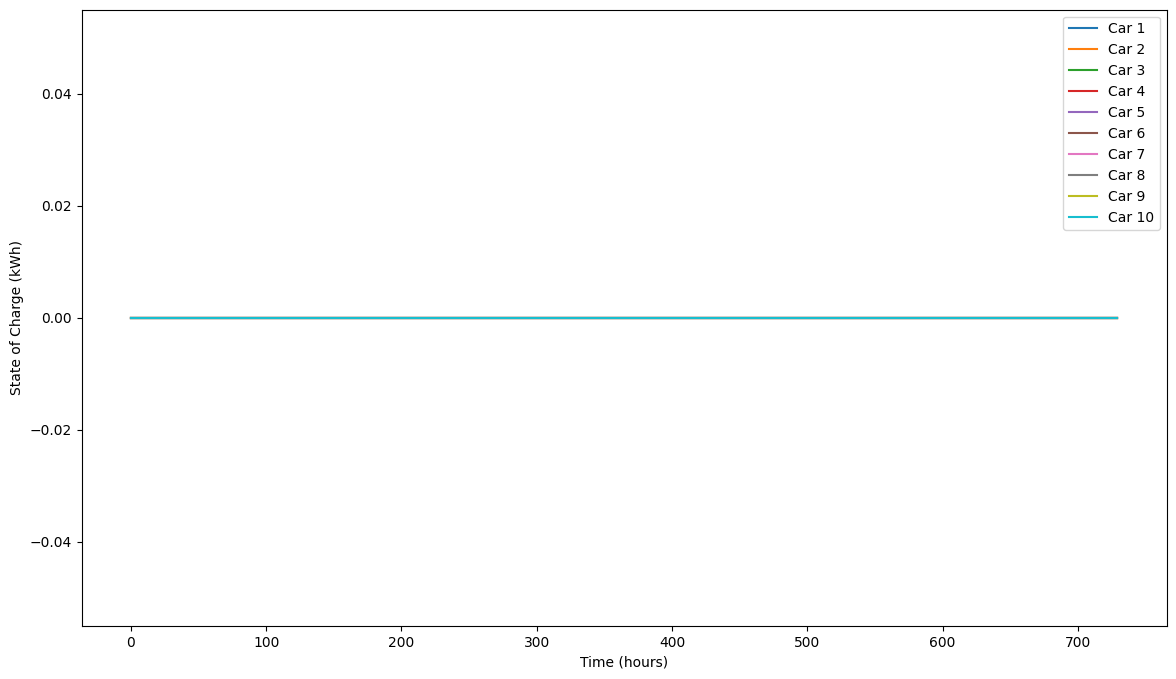

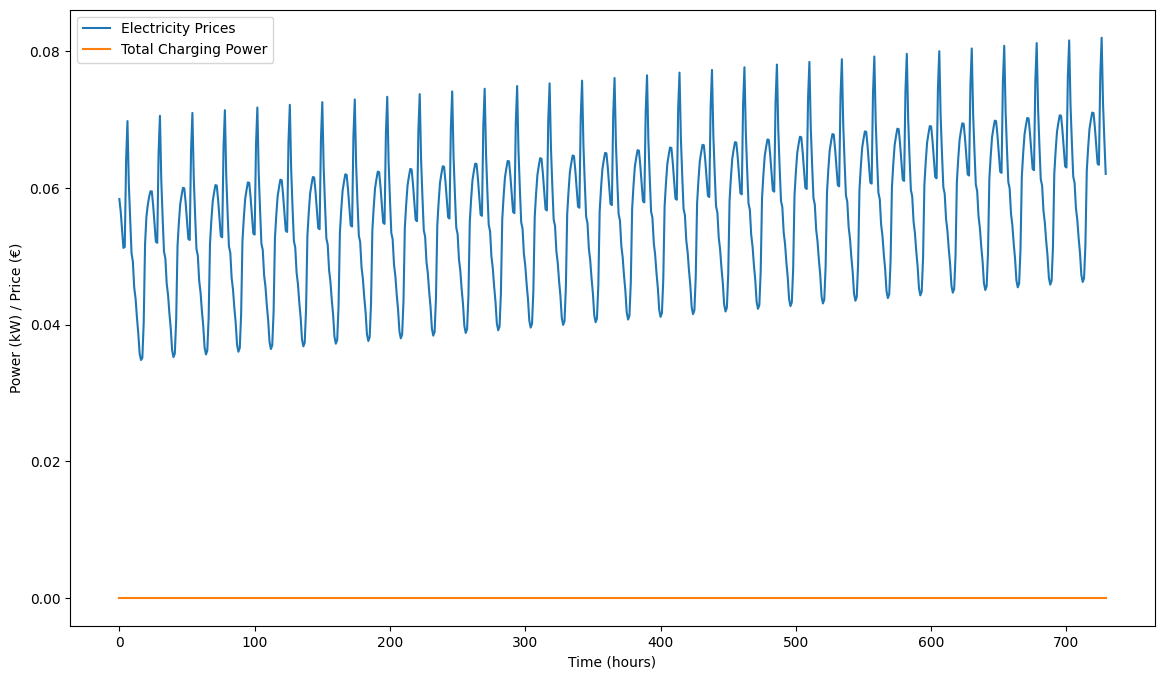

In [6]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

data = pd.read_excel('energy_prices.xlsx', skiprows=1)

# Check the column names
print(data.columns)

# Rename columns if necessary (adjust to match your file's column names)
data.columns = ['datumtijd', 'Inkoop prijs per kWh']

# Ensure the datetime column is in the correct format
data['datumtijd'] = pd.to_datetime(data['datumtijd'])
data.set_index('datumtijd', inplace=True)

# Resample data to hourly average if necessary
# data = data.resample('H').mean()

# Split data into training and test sets
train_data = data.iloc[:730]
test_data = data.iloc[730:1460]


# Fit SARIMA model (parameters can be tuned)
sarima_model = sm.tsa.statespace.SARIMAX(train_data['Inkoop prijs per kWh'],
                                         order=(1, 1, 1),
                                         seasonal_order=(1, 1, 1, 24)).fit()

# Forecast
sarima_forecast = sarima_model.get_forecast(steps=len(test_data))
forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data['Inkoop prijs per kWh'], label='Train')
plt.plot(test_data['Inkoop prijs per kWh'], label='Test')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.ylim(0, 0.3)
plt.show()

# Define the model
model = LpProblem("EV_Charging", LpMinimize)

# Parameters
T = len(test_data)
C = 10  # Number of cars
Pmax = 7  # Maximum charging power per car (kW)
Emax = 50  # Maximum battery capacity per car (kWh)
eta_ch = 0.9  # Charging efficiency
prices = sarima_forecast.predicted_mean.values

# Variables
P = LpVariable.dicts("P", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Pmax, cat='Continuous')
E = LpVariable.dicts("E", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Emax, cat='Continuous')
u = LpVariable.dicts("u", ((c, t) for c in range(C) for t in range(T)), cat='Binary')

# Objective: Minimize total cost
model += lpSum(prices[t] * P[c, t] for c in range(C) for t in range(T))

# Constraints
for c in range(C):
    for t in range(T):
        if t == 0:
            model += E[c, t] == 0  # Initial SoC
        else:
            model += E[c, t] == E[c, t-1] + eta_ch * P[c, t]
        model += P[c, t] <= Pmax * u[c, t]  # Power limits
        model += E[c, t] <= Emax  # SoC limits

# Solve the problem
model.solve()

# Extract results
charging_power = pd.DataFrame([[P[c, t].varValue for t in range(T)] for c in range(C)])
soc = pd.DataFrame([[E[c, t].varValue for t in range(T)] for c in range(C)])

# Plot the State of Charge (SoC) for each car
plt.figure(figsize=(14, 8))
for c in range(C):
    plt.plot(soc.iloc[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('State of Charge (kWh)')
plt.legend()
plt.show()

# Plot the charging power against electricity prices
plt.figure(figsize=(14, 8))
plt.plot(prices, label='Electricity Prices')
plt.plot(charging_power.sum(axis=0), label='Total Charging Power')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW) / Price (€)')
plt.legend()
plt.show()


Index(['datumtijd', 'Inkoop prijs per kWh'], dtype='object')
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All 

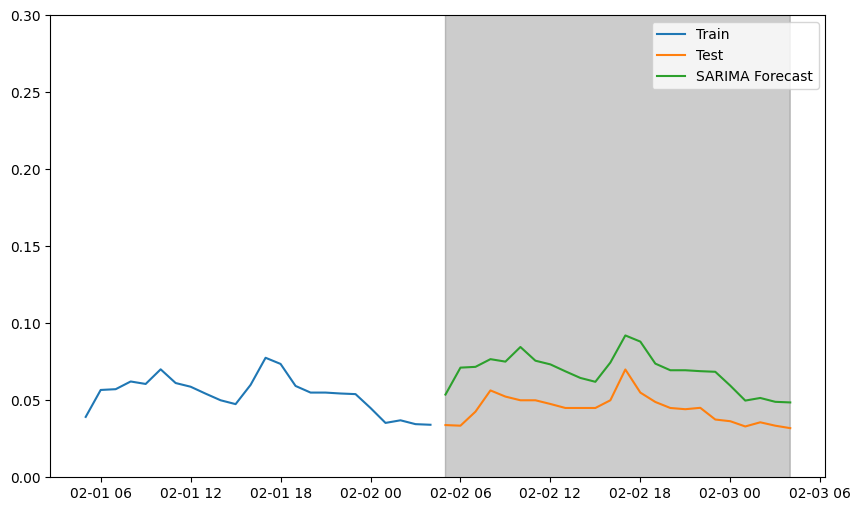

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/62d0768db7f24af985e8d16028461283-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/62d0768db7f24af985e8d16028461283-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 975 COLUMNS
At line 3366 RHS
At line 4337 BOUNDS
At line 5058 ENDATA
Problem MODEL has 970 rows, 720 columns and 1670 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.8086 - 0.00 seconds
Cgl0004I processed model has 10 rows, 220 columns (0 integer (0 of which binary)) and 220 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 13.8086 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 sec

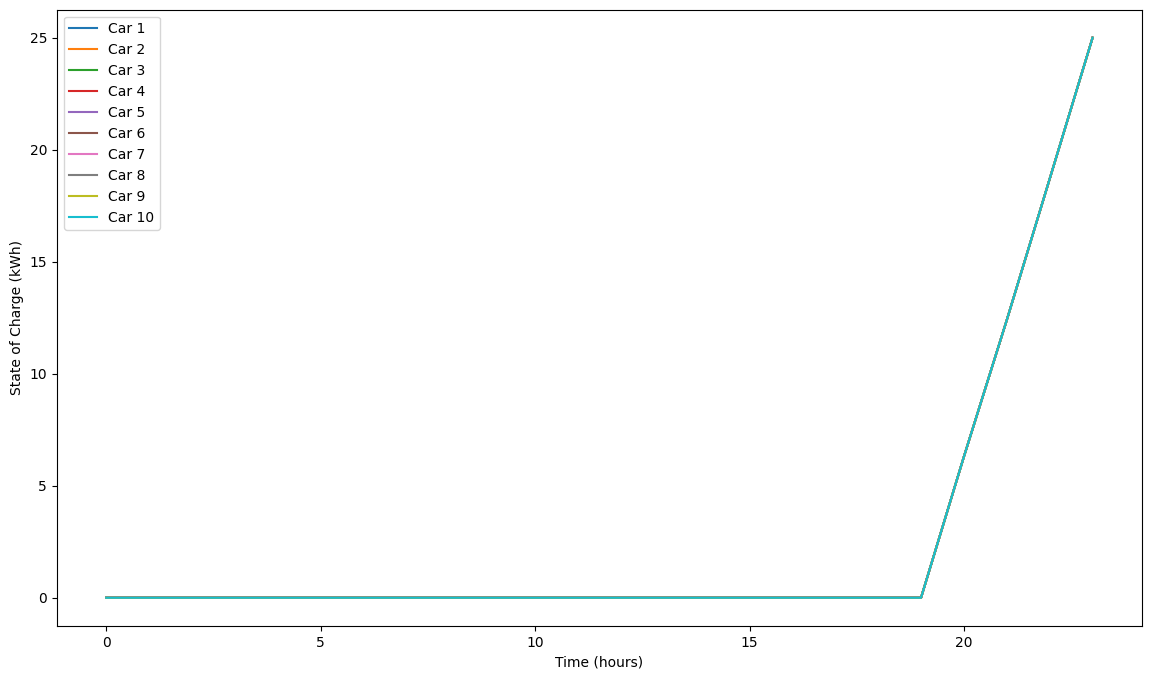

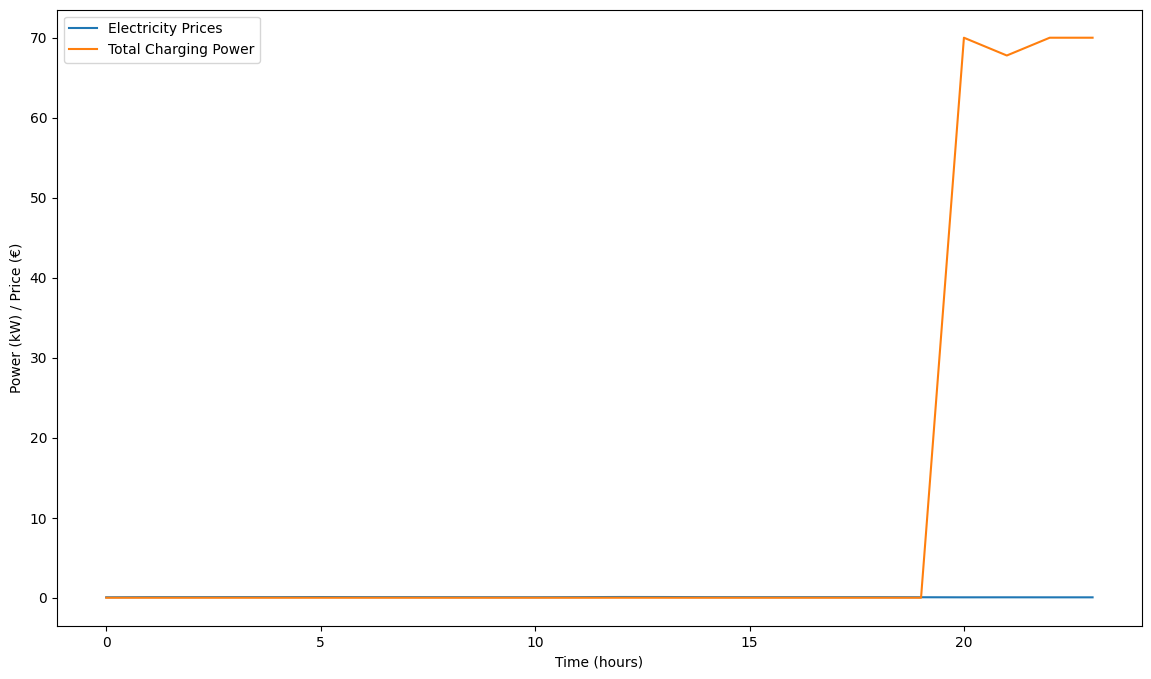

In [17]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

# Load data
data = pd.read_excel('energy_prices.xlsx', skiprows=1)

# Check the column names
print(data.columns)

# Rename columns if necessary (adjust to match your file's column names)
data.columns = ['datumtijd', 'Inkoop prijs per kWh']

# Ensure the datetime column is in the correct format
data['datumtijd'] = pd.to_datetime(data['datumtijd'])
data.set_index('datumtijd', inplace=True)

# Resample data to hourly average if necessary
# data = data.resample('H').mean()

# Split data into training and test sets
train_data = data.iloc[748:772]
test_data = data.iloc[772:796]

# Fit SARIMA model (parameters can be tuned)
sarima_model = sm.tsa.statespace.SARIMAX(train_data['Inkoop prijs per kWh'],
                                         order=(1, 1, 1),
                                         seasonal_order=(1, 1, 1, 24)).fit()

# Forecast
sarima_forecast = sarima_model.get_forecast(steps=len(test_data))
forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data['Inkoop prijs per kWh'], label='Train')
plt.plot(test_data['Inkoop prijs per kWh'], label='Test')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.ylim(0, 0.3)
plt.show()

# Define the model
model = LpProblem("EV_Charging", LpMinimize)

# Parameters
T = len(test_data)  # Time periods
C = 10  # Number of cars
Pmax = 7  # Maximum charging power per car (kW)
Emax = 50  # Maximum battery capacity per car (kWh)
eta_ch = 0.9  # Charging efficiency
prices = sarima_forecast.predicted_mean.values  # Forecasted prices

# Variables
P = LpVariable.dicts("P", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Pmax, cat='Continuous')
E = LpVariable.dicts("E", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Emax, cat='Continuous')
u = LpVariable.dicts("u", ((c, t) for c in range(C) for t in range(T)), cat='Binary')

# Objective: Minimize total cost
model += lpSum(prices[t] * P[c, t] for c in range(C) for t in range(T))

# Constraints
for c in range(C):
    for t in range(T):
        if t == 0:
            model += E[c, t] == 0  # Initial State of Charge (SoC)
        else:
            model += E[c, t] == E[c, t-1] + eta_ch * P[c, t]  # Update SoC based on charging
        model += P[c, t] <= Pmax * u[c, t]  # Ensure power constraints
        model += E[c, t] <= Emax  # Ensure SoC doesn't exceed maximum capacity
        model += P[c, t] >= 0  # Ensure non-negative power

# Ensure at least some charging happens by setting a minimum state of charge requirement
for c in range(C):
    model += E[c, T-1] >= Emax * 0.5  # Ensure at least 50% SoC by the end of the time period

# Solve the problem
model.solve()

# Extract results
charging_power = pd.DataFrame([[P[c, t].varValue for t in range(T)] for c in range(C)])
soc = pd.DataFrame([[E[c, t].varValue for t in range(T)] for c in range(C)])

# Plot the State of Charge (SoC) for each car
plt.figure(figsize=(14, 8))
for c in range(C):
    plt.plot(soc.iloc[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('State of Charge (kWh)')
plt.legend()
plt.show()

# Plot the charging power against electricity prices
plt.figure(figsize=(14, 8))
plt.plot(prices, label='Electricity Prices')
plt.plot(charging_power.sum(axis=0), label='Total Charging Power')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW) / Price (€)')
plt.legend()
plt.show()


Index(['datumtijd', 'Inkoop prijs per kWh'], dtype='object')
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All 

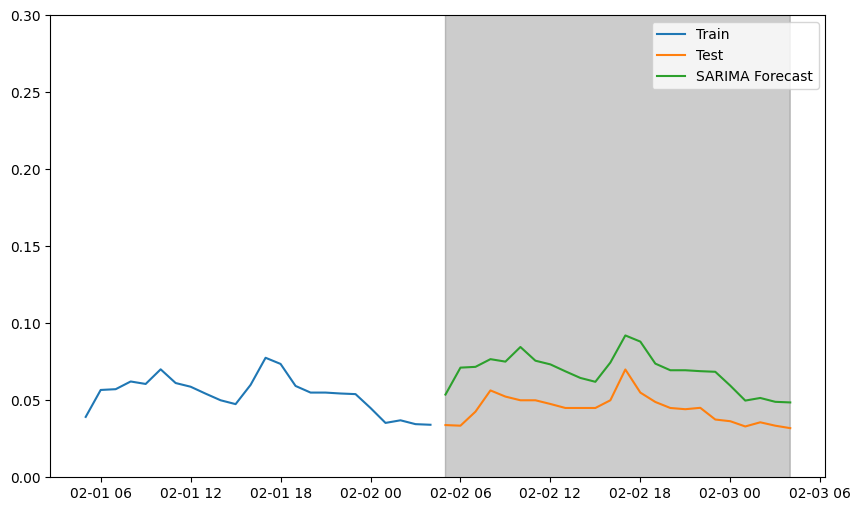

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f7beec27479842b0a6fd4562d8e67871-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/f7beec27479842b0a6fd4562d8e67871-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 999 COLUMNS
At line 3630 RHS
At line 4625 BOUNDS
At line 5346 ENDATA
Problem MODEL has 994 rows, 720 columns and 1910 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.6422 - 0.00 seconds
Cgl0004I processed model has 33 rows, 230 columns (0 integer (0 of which binary)) and 460 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.6422 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 sec

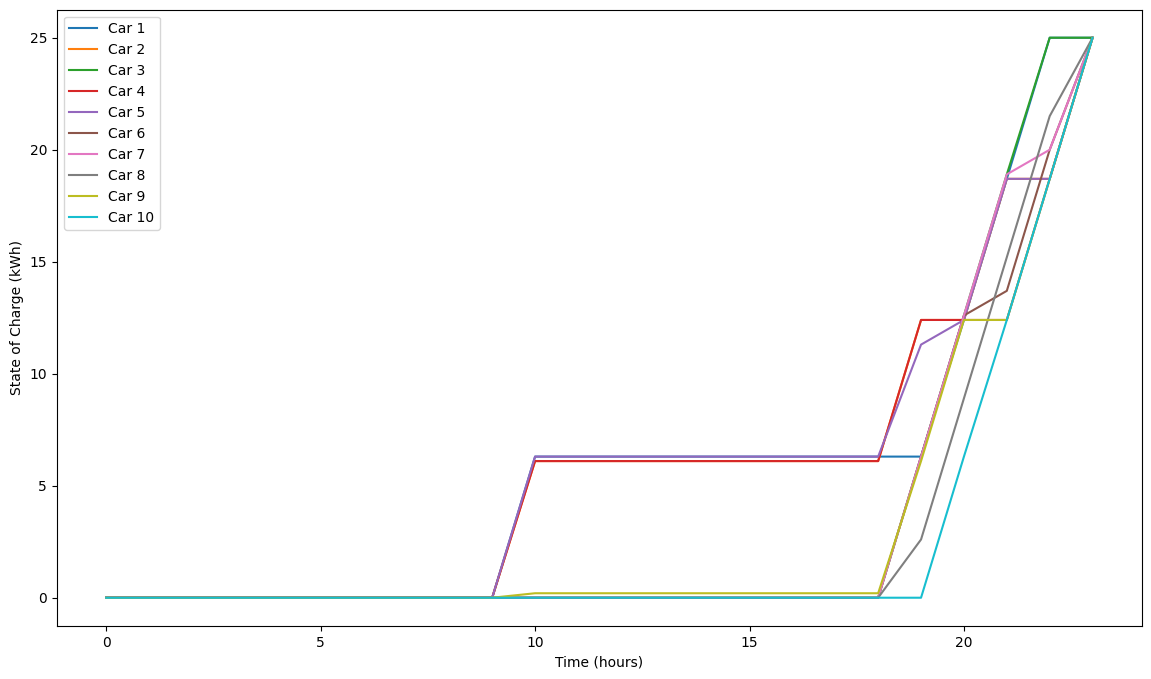

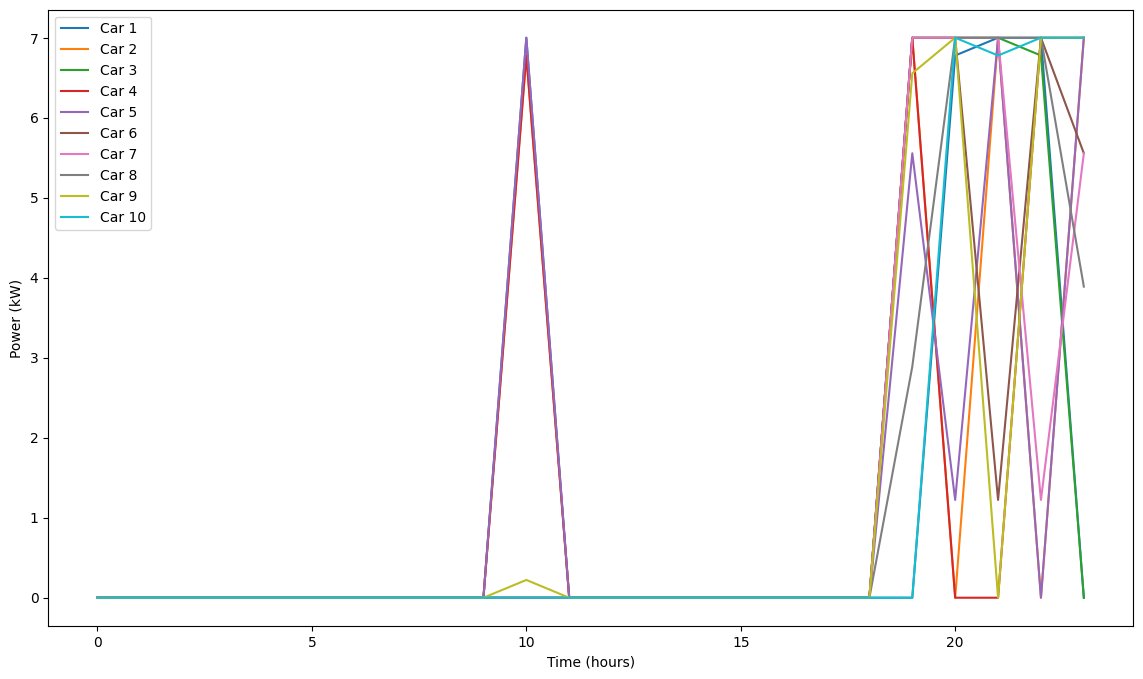

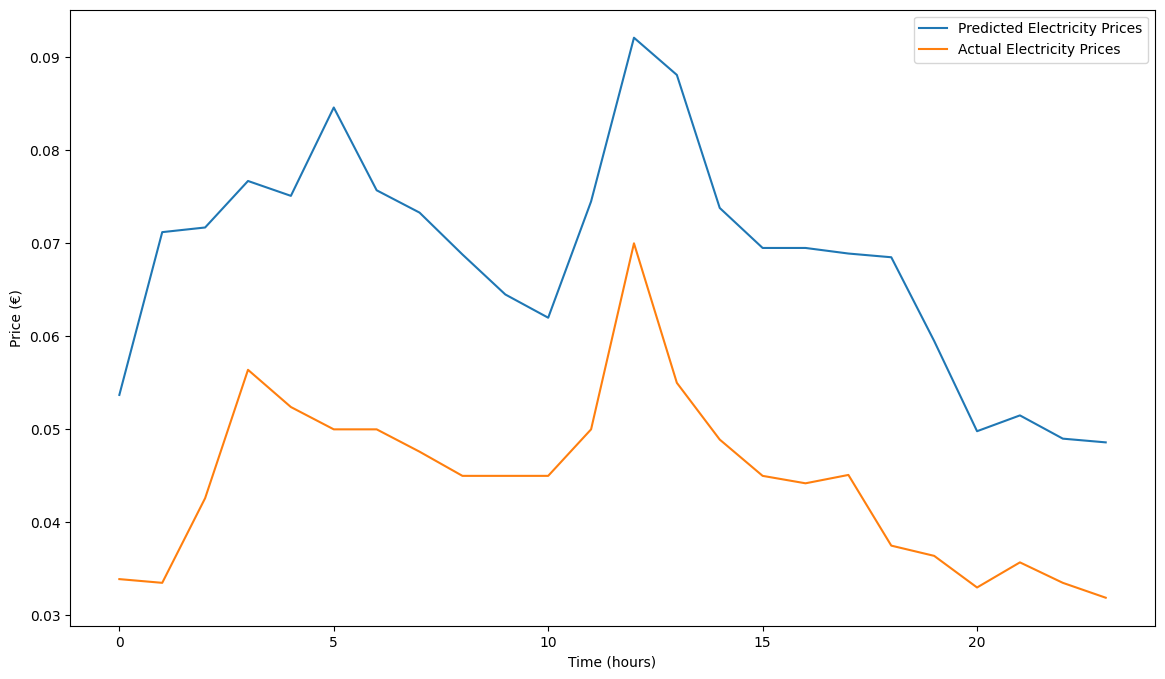

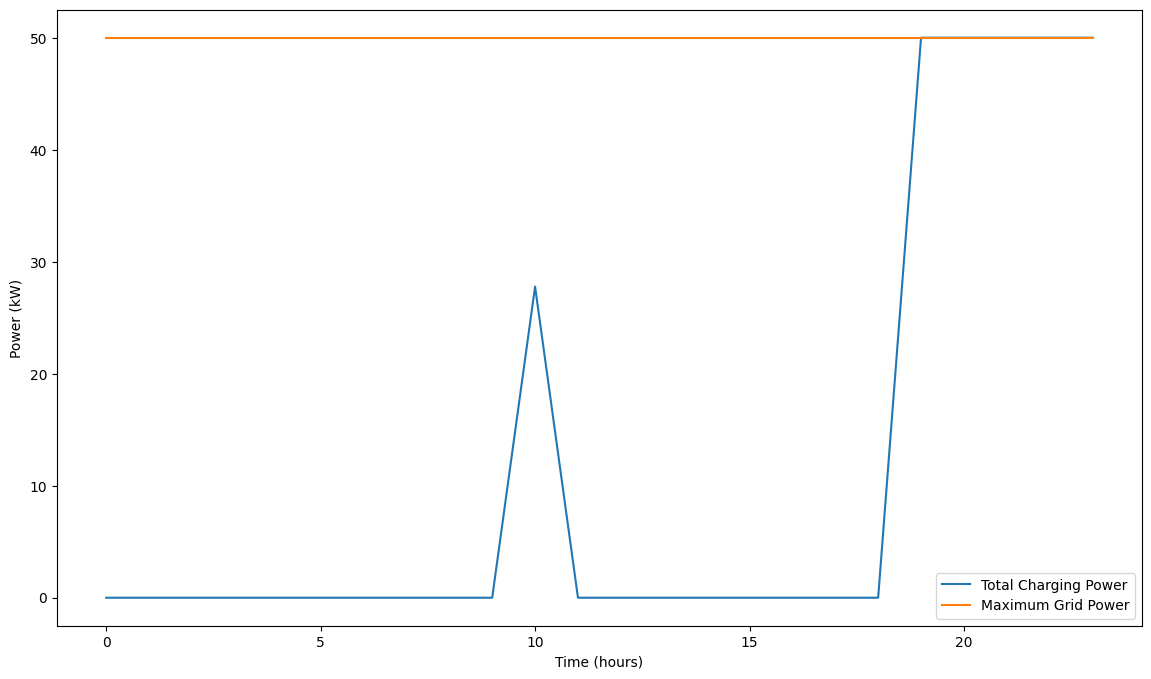

In [29]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

# Load data
data = pd.read_excel('energy_prices.xlsx', skiprows=1)

# Check the column names
print(data.columns)

# Rename columns if necessary (adjust to match your file's column names)
data.columns = ['datumtijd', 'Inkoop prijs per kWh']

# Ensure the datetime column is in the correct format
data['datumtijd'] = pd.to_datetime(data['datumtijd'])
data.set_index('datumtijd', inplace=True)

# Split data into training and test sets
train_data = data.iloc[748:772]
test_data = data.iloc[772:796]

# Fit SARIMA model (parameters can be tuned)
sarima_model = sm.tsa.statespace.SARIMAX(train_data['Inkoop prijs per kWh'],
                                         order=(1, 1, 1),
                                         seasonal_order=(1, 1, 1, 24)).fit()

# Forecast
sarima_forecast = sarima_model.get_forecast(steps=len(test_data))
forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data['Inkoop prijs per kWh'], label='Train')
plt.plot(test_data['Inkoop prijs per kWh'], label='Test')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.ylim(0, 0.3)
plt.show()

# Define the model
model = LpProblem("EV_Charging", LpMinimize)

# Parameters
T = len(test_data)  # Time periods
C = 10  # Number of cars
Pmax = 7  # Maximum charging power per car (kW)
Emax = 50  # Maximum battery capacity per car (kWh)
eta_ch = 0.9  # Charging efficiency
prices = sarima_forecast.predicted_mean.values  # Forecasted prices
Pgrid_max = 50  # Maximum total charging power (kW)

# Variables
P = LpVariable.dicts("P", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Pmax, cat='Continuous')
E = LpVariable.dicts("E", ((c, t) for c in range(C) for t in range(T)), lowBound=0, upBound=Emax, cat='Continuous')
u = LpVariable.dicts("u", ((c, t) for c in range(C) for t in range(T)), cat='Binary')

# Constraints
for c in range(C):
    for t in range(T):
        if t == 0:
            model += E[c, t] == 0  # Initial State of Charge (SoC)
        else:
            model += E[c, t] == E[c, t-1] + eta_ch * P[c, t]  # Update SoC based on charging
        model += P[c, t] <= Pmax * u[c, t]  # Ensure power constraints
        model += E[c, t] <= Emax  # Ensure SoC doesn't exceed maximum capacity
        model += P[c, t] >= 0  # Ensure non-negative power

# Total power limit constraint
for t in range(T):
    model += lpSum(P[c, t] for c in range(C)) <= Pgrid_max

# Ensure at least some charging happens by setting a minimum state of charge requirement
for c in range(C):
    model += E[c, T-1] >= Emax * 0.5  # Ensure at least 50% SoC by the end of the time period

# Objective: Minimize total cost
model += lpSum(prices[t] * P[c, t] for c in range(C) for t in range(T))

# Solve the problem
model.solve()

# Extract results
charging_power = pd.DataFrame([[P[c, t].varValue for t in range(T)] for c in range(C)])
soc = pd.DataFrame([[E[c, t].varValue for t in range(T)] for c in range(C)])

# Plot the State of Charge (SoC) for each car
plt.figure(figsize=(14, 8))
for c in range(C):
    plt.plot(soc.iloc[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('State of Charge (kWh)')
plt.legend()
plt.show()

# Plot the charging power for each car
plt.figure(figsize=(14, 8))
for c in range(C):
    plt.plot(charging_power.iloc[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

# Plot the predicted and actual electricity prices
plt.figure(figsize=(14, 8))
plt.plot(prices, label='Predicted Electricity Prices')
plt.plot(test_data['Inkoop prijs per kWh'].values, label='Actual Electricity Prices')
plt.xlabel('Time (hours)')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

# Plot the total charging power and strain on the EV grid
plt.figure(figsize=(14, 8))
plt.plot(charging_power.sum(axis=0), label='Total Charging Power')
plt.plot([Pgrid_max for _ in range(T)], label='Maximum Grid Power')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()
